# Modèles prédictifs pour compléter les données manquantes

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Enrichissement des données
from sklearn.impute import SimpleImputer
# Régression logistique
from sklearn.linear_model import LogisticRegression
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline

#### Charger et compléter les données

In [34]:
data = pd.read_csv("data/adult.csv", na_values='?')
data.drop('income', axis=1, inplace=True)

In [35]:
def clean_and_complete(data):
    # complete
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    data['workclass'] = imp.fit_transform(data[['workclass']])
    data['native.country'] = imp.fit_transform(data[['native.country']])
    # remove useless info
    data.drop('education', axis=1, inplace=True)

In [36]:
clean_and_complete(data)

In [37]:
data.head()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,90,Private,77053,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States
1,82,Private,132870,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
2,66,Private,186061,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States
3,54,Private,140359,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,264663,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
dtypes: int64(6), object(7)
memory usage: 3.2+ MB


#### Préparer les données pour les modèles

In [39]:
def transform(data):
    data['native.country'] = [1 if x == 'United-States' else 0 for x in data['native.country']]
    data['workclass'] = [1 if x == 'Private' else 0 for x in data['workclass']]
    data['race'] = [1 if x == 'White' else 0 for x in data['race']]
    data['sex'] = [1 if x == 'Male' else 0 for x in data['sex']]

In [40]:
transform(data)

In [41]:
def train_set(data):
    return data.dropna()

In [42]:
train = train_set(data)

In [43]:
def prediction_set(data):
    return data[data['occupation'].isnull()].drop('occupation', axis=1)

In [44]:
prediction = pd.get_dummies(prediction_set(data))

In [ ]:
train.head()

In [ ]:
train.info()

In [ ]:
prediction.head()

In [ ]:
prediction.info()

#### Modèles de prédiction

##### 1.  LogisticRegression

In [ ]:
X = pd.get_dummies(train.drop('occupation', axis=1))
Y = train['occupation']
clf_reg = LogisticRegression()
clf_reg.fit(X, Y)
result = clf_reg.predict(prediction)

In [ ]:
prediction['occupation']=[x for x in result]

In [ ]:
# Calcul du score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf_reg, X, Y, cv=5, scoring='accuracy') #accuracy, f1
np.mean(scores),np.std(scores)

##### 2.  KNN Neighbors

In [16]:
X = pd.get_dummies(train.drop('occupation', axis=1))
Y = train['occupation']
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X,Y)
result_knn = clf_knn.predict(prediction)

In [17]:
prediction['occupation']=[x for x in result_knn]

In [18]:
# Calcul du score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf_knn, X, Y, cv=5, scoring='accuracy') #accuracy, f1
np.mean(scores),np.std(scores)

(0.13626945194731727, 0.009247861951286298)

#### Evaluation de la prédiction

In [19]:
def complete_with_prediction(data, prediction):
    complete_data = data.copy()
    for index in prediction.index:
        complete_data.loc[index,'occupation'] = prediction.loc[index,'occupation']
    return complete_data

In [20]:
df = complete_with_prediction(data, prediction)

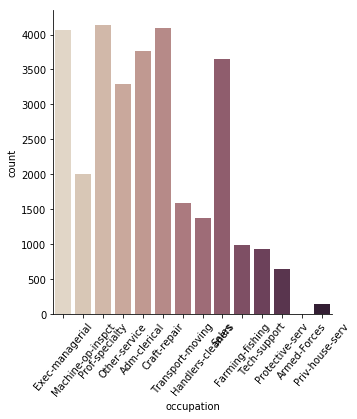

In [31]:
# Données brutes
g = sns.catplot(x="occupation", kind="count", palette="ch:.25", data=data)
g.set_xticklabels(rotation=50)

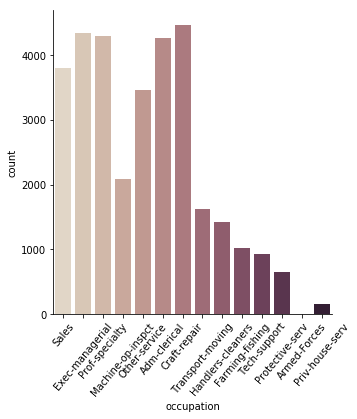

In [32]:
# Données complétées
g = sns.catplot(x="occupation", kind="count", palette="ch:.25", data=df) 
g.set_xticklabels(rotation=50)

In [21]:
total = data.groupby('occupation').count()['age']
percent = round(data.groupby('occupation').count()['age']/data.dropna()['age'].count(),6)*100
stats_ini = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# stats_ini.loc[len(stats_ini)]=[sum(stats_ini['Total']),sum(stats_ini['Percent'])]

In [22]:
total = df.groupby('occupation').count()['age']
percent = round(df.groupby('occupation').count()['age']/df['age'].count(),6)*100
stats_fin = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# stats_fin.loc[len(stats_fin)]=[sum(stats_fin['Total']),sum(stats_fin['Percent'])]

In [23]:
stats_ini

,Total,Percent
occupation,,
Adm-clerical,3770,12.2729
Armed-Forces,9,0.0293
Craft-repair,4099,13.3440
Exec-managerial,4066,13.2365
Farming-fishing,994,3.2359
Handlers-cleaners,1370,4.4599
Machine-op-inspct,2002,6.5174
Other-service,3295,10.7266
Priv-house-serv,149,0.4851


In [24]:
stats_fin

,Total,Percent
occupation,,
Adm-clerical,4263,13.0923
Armed-Forces,9,0.0276
Craft-repair,4470,13.7281
Exec-managerial,4338,13.3227
Farming-fishing,1029,3.1602
Handlers-cleaners,1421,4.3641
Machine-op-inspct,2084,6.4003
Other-service,3466,10.6446
Priv-house-serv,151,0.4637


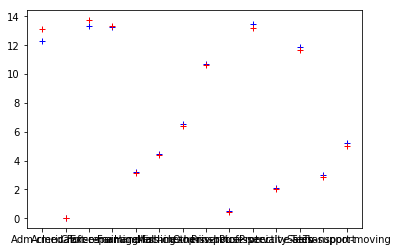

In [25]:
# Comparaison en pourcentage
fig = plt.figure()
plt.plot(stats_ini.index, stats_ini['Percent'],'b+')  # en bleu : données brutes
plt.plot(stats_fin.index, stats_fin['Percent'],'r+')  # en rouge : données complétées par les prédictions
plt.show()

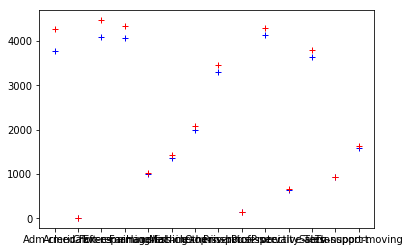

In [26]:
# Comparaison en nombre
fig = plt.figure()
plt.plot(stats_ini.index, stats_ini['Total'],'b+')  # en bleu : données brutes
plt.plot(stats_fin.index, stats_fin['Total'],'r+')  # en rouge : données complétées par les prédictions
plt.show()

#### Comparaison avec le 'most frequent fill' segmenté en male/female

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
age               32561 non-null int64
workclass         32561 non-null int64
fnlwgt            32561 non-null int64
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null int64
sex               32561 non-null int64
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null int64
dtypes: int64(10), object(3)
memory usage: 3.2+ MB


In [48]:
mfill = data.copy()  # 'manual filling'
mfill[mfill['sex']==0] = mfill[mfill['sex']==0].fillna('Craft-repair')
mfill[mfill['sex']==1] = mfill[mfill['sex']==1].fillna('Adm-clerical')

In [50]:
total = mfill.groupby('occupation').count()['age']
percent = round(mfill.groupby('occupation').count()['age']/mfill['age'].count(),6)*100
stats_fin = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# stats_fin.loc[len(stats_fin)]=[sum(stats_fin['Total']),sum(stats_fin['Percent'])]

In [51]:
stats_fin

,Total,Percent
occupation,,
Adm-clerical,4772,14.6556
Armed-Forces,9,0.0276
Craft-repair,4940,15.1715
Exec-managerial,4066,12.4873
Farming-fishing,994,3.0527
Handlers-cleaners,1370,4.2075
Machine-op-inspct,2002,6.1485
Other-service,3295,10.1195
Priv-house-serv,149,0.4576


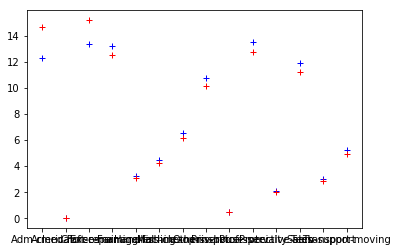

In [52]:
# Comparaison en pourcentage
fig = plt.figure()
plt.plot(stats_ini.index, stats_ini['Percent'],'b+')  # en bleu : données brutes
plt.plot(stats_fin.index, stats_fin['Percent'],'r+')  # en rouge : données complétées par les prédictions
plt.show()